In [1]:
# for the functions
import pandas as pd
import numpy as np
import requests
from datetime import date, datetime, timedelta
# for the tests
from arable.client import ArableClient
from io import StringIO
import matplotlib.pyplot as plt

In [2]:
# grab some mark data
email = 'danielle@arable.com'
device = 'A000176' 
a = ArableClient()
a.connect(email, 'arable1', 'arable')

sta = "2017-07-01"
end = "2017-07-31"
#end = datetime.now()
#end = end.strftime("%Y-%m-%dT%H:%M:%SZ")

df = a.query(select='all', 
               format='csv', devices=[device], 
               measure="hourly", 
               order="time", 
               end=end, start=sta, 
               limit=10000) 

df = StringIO(df)
df = pd.read_csv(df, sep=',', error_bad_lines=False)

# make sure I'm using a datetime object
df['time'] = pd.to_datetime(df['time'])

# df['RH'] = df['RH']/100.0
# df['P'] = P
# df.to_csv('A176_hourly.csv')

# data.head(2)
# data.tail(2)

In [4]:
list(df)

['time',
 'device',
 'location',
 'lat',
 'long',
 'B1dw',
 'B1uw',
 'B2dw',
 'B2uw',
 'B3dw',
 'B3uw',
 'B4dw',
 'B4uw',
 'B5dw',
 'B5uw',
 'B6dw',
 'B6uw',
 'B7dw',
 'B7uw',
 'LWdw',
 'LWuw',
 'LfW',
 'P',
 'SLP',
 'PARdw',
 'PARuw',
 'RH',
 'SWdw',
 'SWuw',
 'Tabove',
 'Tair',
 'Tbelow',
 'Tdew',
 'prate',
 'precip']

In [319]:
# FAO 56 eq 6 - expression for daily ET
# 37.5 = 900/24
# 1 mm/day = 0.408 MJ/m2/day = 1/lambda

from lib.physics import *


u = 2.  # default wind speed recommended by Rick Allen (m/s)
rn = (df.SWdw + df.SWuw + df.LWdw + df.LWuw) * 3600 / 1000000  # Net radiation (MJ m-2 hr-1)  # NOQA
# VPD = es - ea  # vapor pressure deficit (kPa)
vpd = VPD_(df.Tair, df.RH)
gamma = 0.000665 * df.P  # psychrometric constant (kPa C-1)
# delta = slope of saturation vapor pressure curve
# the seemingly extraneous parens are necessary...do not remove
delta = (4098. * (0.6108 * np.exp((17.27 * df.Tair) / (df.Tair + 237.3)) / ((df.Tair + 237.3) ** 2)))  # NOQA
eto_mm_hr = ((0.408 * delta * rn) + (
        gamma * (37.5 / (df.Tair + 273.)) * u * vpd)) / (
                    delta + (gamma * (1. + 0.34 * u)))  # mm/hr

df['ET_FAO56'] = eto_mm_hr
df['term2'] = 1. / (Tk_(df.Tair) * u * VPD)

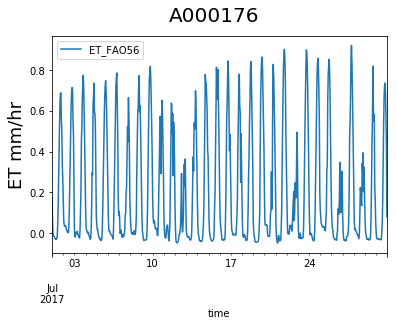

In [320]:
plt.figure(figsize=(200,100))
df.plot('time', ['ET_FAO56'])
plt.suptitle(device, fontsize=20)
plt.ylabel('ET mm/hr', fontsize=18)
plt.show()

In [333]:
# FAO 56 eq 6 - expression for daily ET
# 37.5 = 900/24

from lib.physics import *

u = 2.  # m/s
Rn = (df.SWdw + df.SWuw + df.LWdw + df.LWuw) # J / m2 / s
VPD = VPD_(df.Tair, df.RH) # kPa
gamma = gamma_(df.Tair, df.P) # kPa / C
Lambda = lambda_(Tk_(df.Tair)) # J / g
delta = s_(df.Tair) # kPa / C
sec_per_hr = 3600.

LE = ((Rn * delta) + (gamma * 37.5 / Tk_(df.Tair) * u * VPD)) / (delta + (gamma * (1. + 0.34 * u)))
eto_mm_hr = LE / Lambda * sec_per_hr / 1000 # mm/hr

df['Rn'] = Rn
df['VPD'] = vpd
df['term2'] = 1. / (Tk_(df.Tair) * u * VPD)
df['ET_FAO56'] = eto_mm_hr

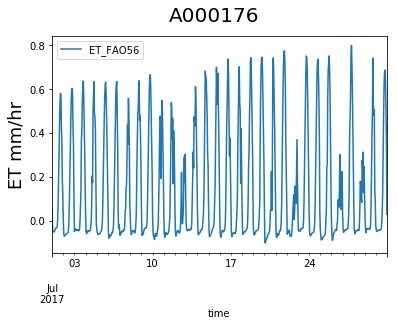

In [334]:
plt.figure(figsize=(200,100))
df.plot('time', ['ET_FAO56'])
plt.suptitle(device, fontsize=20)
plt.ylabel('ET mm/hr', fontsize=18)
plt.show()

In [103]:
def moist_air_mol_(xT, xRH, xP=P):  # pragma: no cover
    """ mass of moist air: mol / m3

    :param xT:
    :param xRH:
    :param xP:
    :return:
    """
    return dry_air_(xT, xRH, xP) * 1000.0 / Mair + air_h2o_(xT, xRH, xP) / 1000.0 / Mh2o

In [196]:
from lib.physics import *

gamma = gamma_(df.Tair, df.P)
Lambda = lambda_mol_(Tk_(df.Tair)) # J/mol
#rho = moist_air_mol_(df.Tair, df.RH, df.P)
rho = dry_air_mol_(df.Tair, df.RH, df.P)
mm_per_mol = Mh2o / (100.*100.*0.1)

Rn = (df.SWdw + df.SWuw + df.LWdw + df.LWuw) # J/m2/s
dT = df.Tbelow - df.Tair
VPD = esat_(df.Tbelow) - ea_(df.Tair, df.RH)
rH = rpbl_heat_(2., 1., 2.)
gH = rho/rH
gc = (Rn/Cp_mol - gH*dT) * (gamma/VPD)

rS = rho/gc - rH
rS = np.minimum(np.maximum(rS, 0), 500)
LE = Cp_mol/gamma*gc*VPD

ETA = LE / Lambda * mm_per_mol * 3600 # mm/hr

df['Rn'] = Rn
df['LE'] = LE
df['ETA'] = ETA
df['rho'] = rho
df['VPD'] = VPD
df['dT'] = dT
df['gc'] = gc
df['rS'] = rS

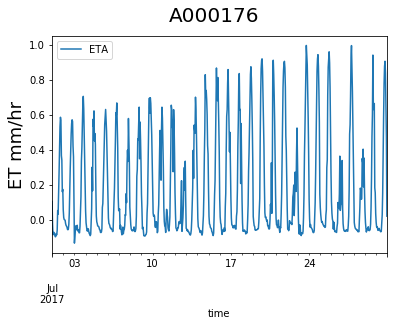

In [197]:
plt.figure(figsize=(200,100))
df.plot('time', ['ETA'])
plt.suptitle(device, fontsize=20)
plt.ylabel('ET mm/hr', fontsize=18)
plt.show()

In [1]:
list(df)

NameError: name 'df' is not defined